# Prepare Dataset for Model Training and Evaluating

# Amazon Customer Reviews Dataset

https://s3.amazonaws.com/dsoaws/amazon-reviews-pds/readme.html

## Schema

- `marketplace`: 2-letter country code (in this case all "US").
- `customer_id`: Random identifier that can be used to aggregate reviews written by a single author.
- `review_id`: A unique ID for the review.
- `product_id`: The Amazon Standard Identification Number (ASIN).  `http://www.amazon.com/dp/<ASIN>` links to the product's detail page.
- `product_parent`: The parent of that ASIN.  Multiple ASINs (color or format variations of the same product) can roll up into a single parent.
- `product_title`: Title description of the product.
- `product_category`: Broad product category that can be used to group reviews (in this case digital videos).
- `star_rating`: The review's rating (1 to 5 stars).
- `helpful_votes`: Number of helpful votes for the review.
- `total_votes`: Number of total votes the review received.
- `vine`: Was the review written as part of the [Vine](https://www.amazon.com/gp/vine/help) program?
- `verified_purchase`: Was the review from a verified purchase?
- `review_headline`: The title of the review itself.
- `review_body`: The text of the review.
- `review_date`: The date the review was written.

In [1]:
import boto3
import sagemaker
import pandas as pd

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

## Download

Let's start by retrieving a subset of the Amazon Customer Reviews dataset.

In [9]:
!aws s3 cp 's3://dsoaws/amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Software_v1_00.tsv.gz' ./data/

download: s3://dsoaws/amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Software_v1_00.tsv.gz to data/amazon_reviews_us_Digital_Software_v1_00.tsv.gz


In [10]:
import csv

df = pd.read_csv(
    "./data/amazon_reviews_us_Digital_Software_v1_00.tsv.gz",
    delimiter="\t",
    quoting=csv.QUOTE_NONE,
    compression="gzip",
)
df.shape

(102084, 15)

In [11]:
df.head(5)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,17747349,R2EI7QLPK4LF7U,B00U7LCE6A,106182406,CCleaner Free [Download],Digital_Software,4,0,0,N,Y,Four Stars,So far so good,2015-08-31
1,US,10956619,R1W5OMFK1Q3I3O,B00HRJMOM4,162269768,ResumeMaker Professional Deluxe 18,Digital_Software,3,0,0,N,Y,Three Stars,Needs a little more work.....,2015-08-31
2,US,13132245,RPZWSYWRP92GI,B00P31G9PQ,831433899,Amazon Drive Desktop [PC],Digital_Software,1,1,2,N,Y,One Star,Please cancel.,2015-08-31
3,US,35717248,R2WQWM04XHD9US,B00FGDEPDY,991059534,Norton Internet Security 1 User 3 Licenses,Digital_Software,5,0,0,N,Y,Works as Expected!,Works as Expected!,2015-08-31
4,US,17710652,R1WSPK2RA2PDEF,B00FZ0FK0U,574904556,SecureAnywhere Intermet Security Complete 5 De...,Digital_Software,4,1,2,N,Y,Great antivirus. Worthless customer support,I've had Webroot for a few years. It expired a...,2015-08-31


Text(0, 0.5, 'Review Count')

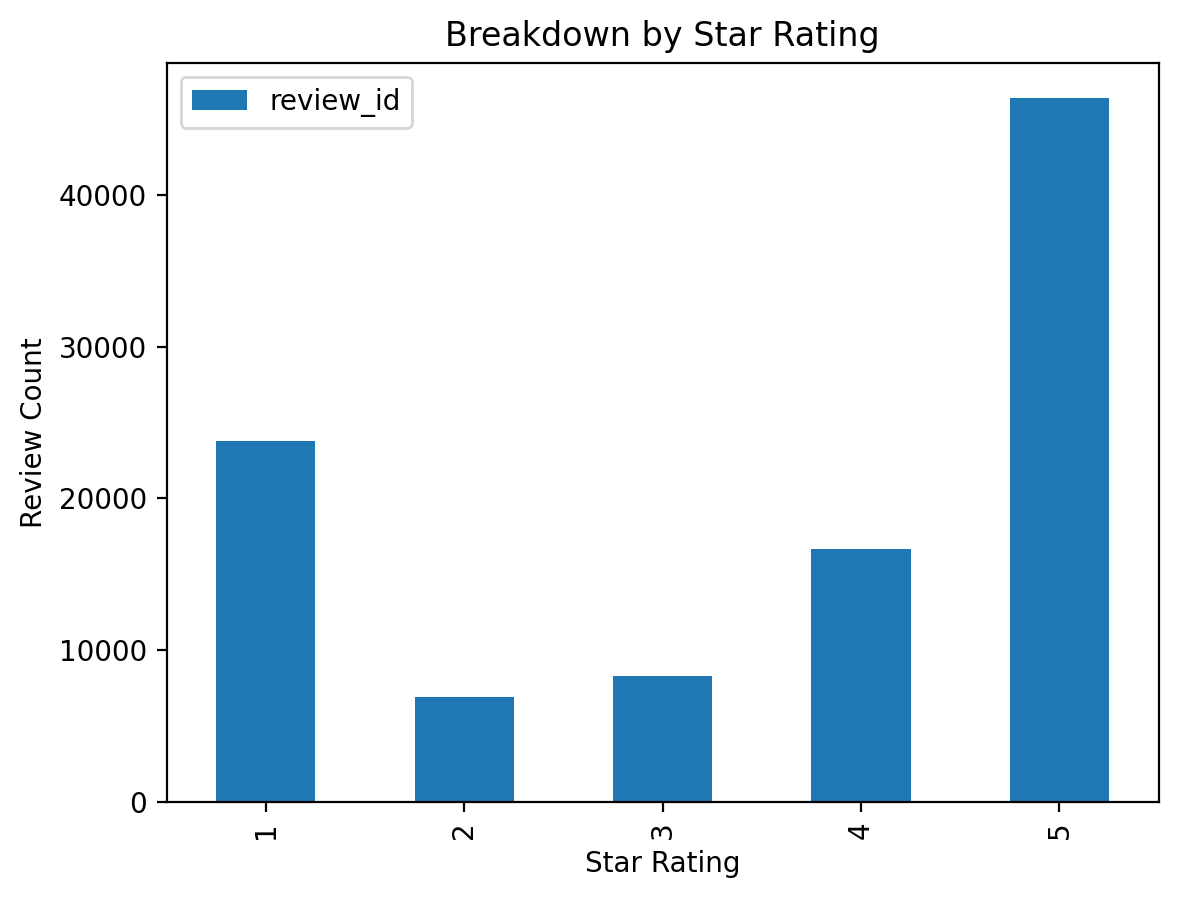

In [12]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

df[["star_rating", "review_id"]].groupby("star_rating").count().plot(kind="bar", title="Breakdown by Star Rating")
plt.xlabel("Star Rating")
plt.ylabel("Review Count")

# Balance the Dataset

In [13]:
print("Shape of dataframe before splitting {}".format(df.shape))

Shape of dataframe before splitting (102084, 15)


In [14]:
# Balance the dataset down to the minority class
df_grouped_by = df.groupby(["star_rating"]) 
df_balanced = df_grouped_by.apply(lambda x: x.sample(df_grouped_by.size().min()).reset_index(drop=True))

df_balanced = df_balanced.reset_index(drop=True)
print("Shape of balanced dataframe {}".format(df_balanced.shape))

Shape of balanced dataframe (34450, 15)


Text(0, 0.5, 'Review Count')

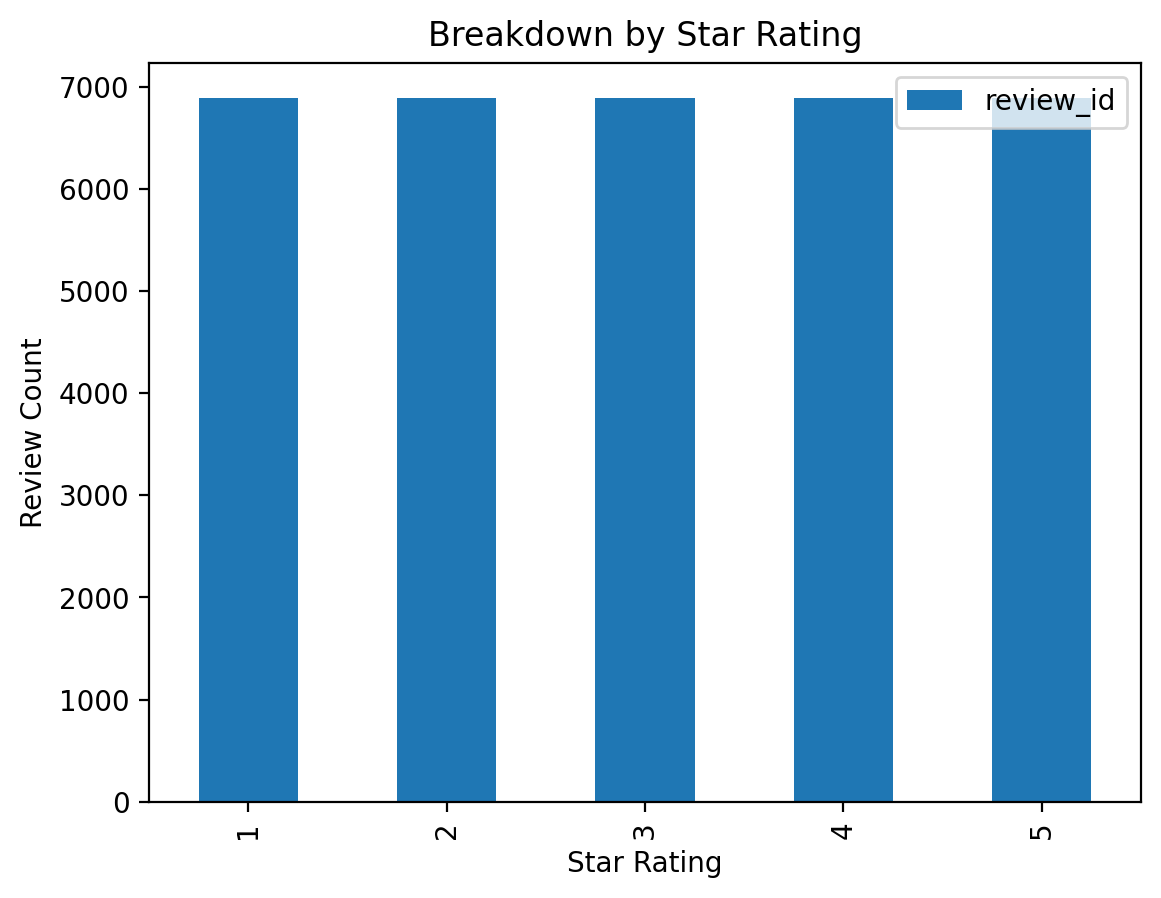

In [15]:
df_balanced[["star_rating", "review_id"]].groupby("star_rating").count().plot(
    kind="bar", title="Breakdown by Star Rating"
)
plt.xlabel("Star Rating")
plt.ylabel("Review Count")

In [16]:
df_balanced.head(5)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,47652876,R35PJ3ALKXTWS8,B00IG20XM4,466462406,avast! GrimeFighter [Download],Digital_Software,1,1,1,N,N,Avoid.,Doesn't work. Absolutely no response received ...,2014-10-15
1,US,6739894,R1KUZWDSZ65541,B008SCMUUA,832031006,Norton Internet Security 2013 - 1 User / 3 PC,Digital_Software,1,1,3,N,N,Fixing Virus and then charging you $99.99.,You buy the product and then you pay them to r...,2013-06-26
2,US,10630965,RPXAG6F94YJD4,B009T8GP1C,292346829,PhotoDirector 4,Digital_Software,1,0,1,N,Y,Can't even open it....,You guys at Amazon should be available to help...,2013-12-22
3,US,29022796,R2CJQ93YAGW1Q8,B008S0IP38,383426331,Quicken Premier 2013,Digital_Software,1,17,17,N,Y,Very buggy,I am really disappointed by this product. Its ...,2012-10-11
4,US,51877055,R3JUWY894GNA7O,B00NG7JVSQ,811978073,TurboTax Deluxe Fed + Efile + State,Digital_Software,1,1,1,N,N,DO NOT WASTE YOUR MONEY,I wish I could give this a ZERO. I'm halfway ...,2015-02-27


# Split the Data into Train, Validation, and Test Sets

In [17]:
from sklearn.model_selection import train_test_split

# Split all data into 90% train and 10% holdout
df_train, df_holdout = train_test_split(df_balanced, test_size=0.10, stratify=df_balanced["star_rating"])

# Split holdout data into 50% validation and 50% test
df_validation, df_test = train_test_split(df_holdout, test_size=0.50, stratify=df_holdout["star_rating"])

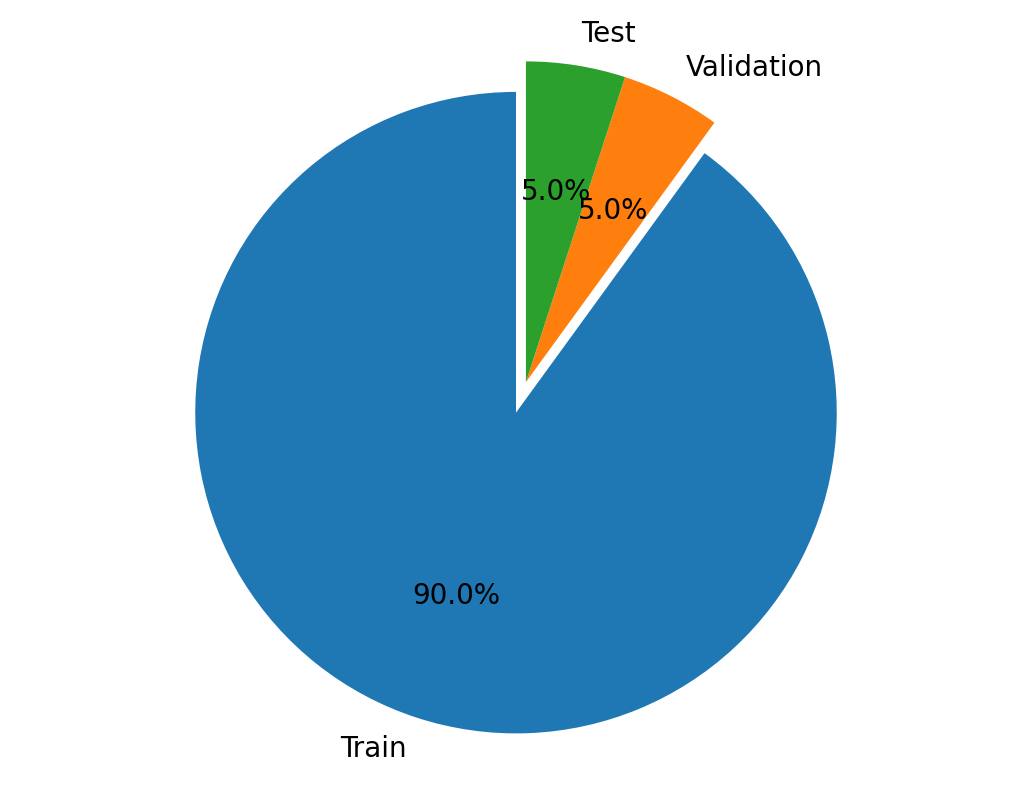

In [18]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ["Train", "Validation", "Test"]
sizes = [len(df_train.index), len(df_validation.index), len(df_test.index)]
explode = (0.1, 0, 0)

fig1, ax1 = plt.subplots()

ax1.pie(sizes, explode=explode, labels=labels, autopct="%1.1f%%", startangle=90)

# Equal aspect ratio ensures that pie is drawn as a circle.
ax1.axis("equal")

plt.show()

# Show 90% Train Data Split

In [19]:
df_train.shape

(31005, 15)

<Axes: title={'center': '90% Train Breakdown by Star Rating'}, xlabel='star_rating'>

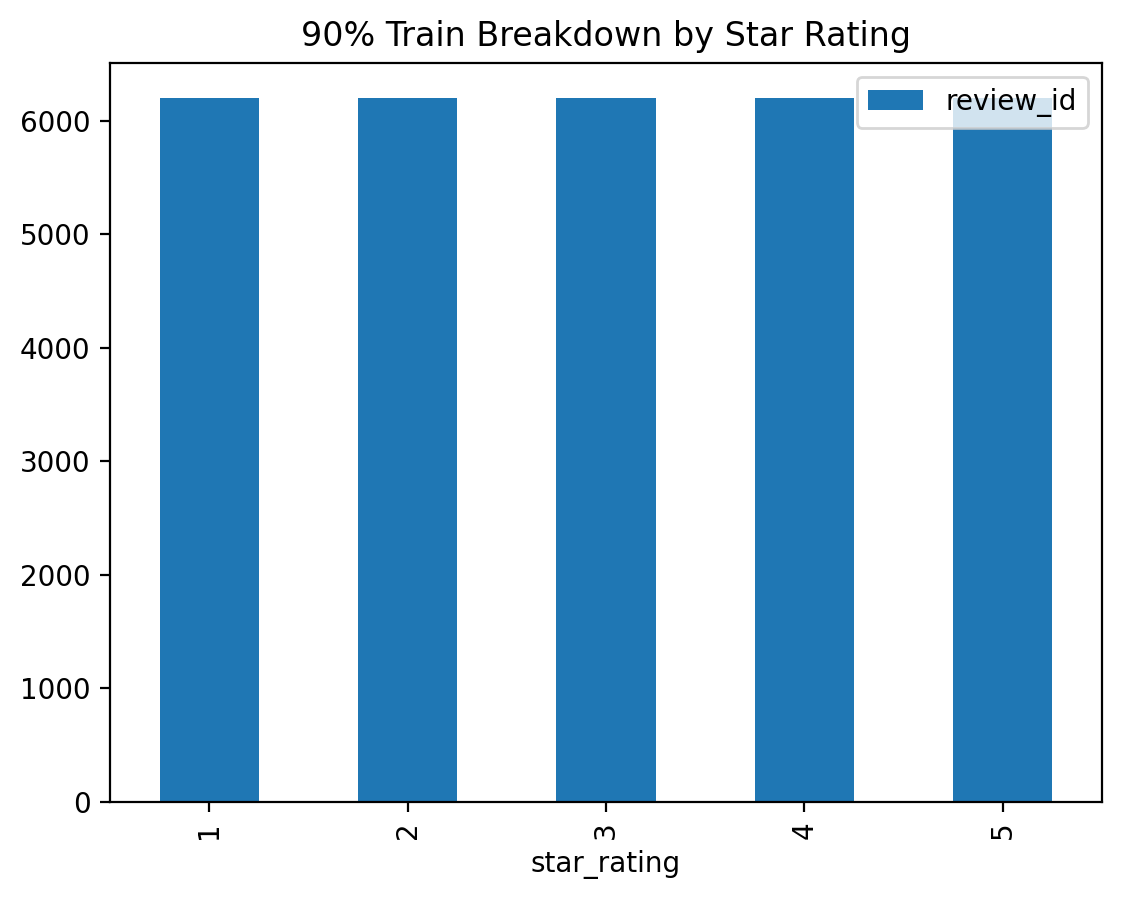

In [21]:
df_train[["star_rating", "review_id"]].groupby("star_rating").count().plot(
    kind="bar", title="90% Train Breakdown by Star Rating"
)

# Show 5% Validation Data Split

In [22]:
df_validation.shape

(1722, 15)

<Axes: title={'center': '5% Validation Breakdown by Star Rating'}, xlabel='star_rating'>

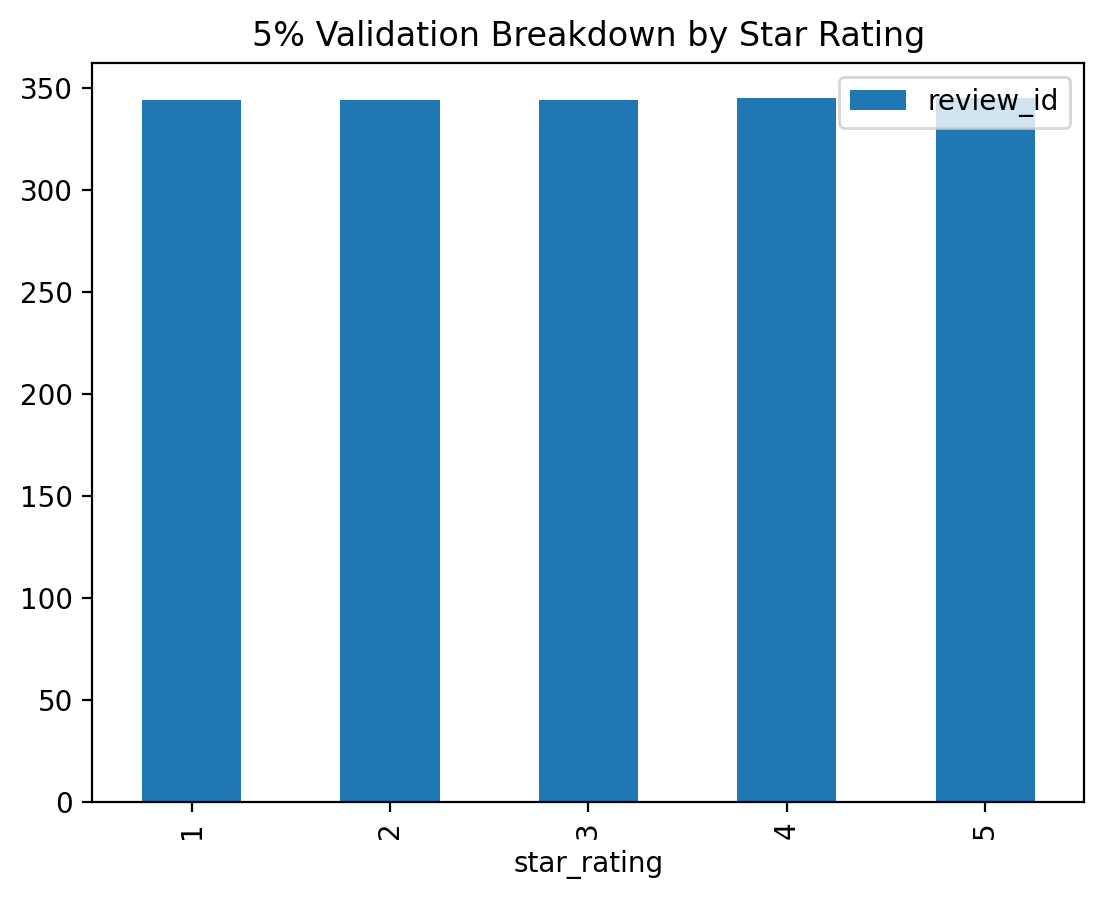

In [23]:
df_validation[["star_rating", "review_id"]].groupby("star_rating").count().plot(
    kind="bar", title="5% Validation Breakdown by Star Rating"
)

# Show 5% Test Data Split

In [24]:
df_test.shape

(1723, 15)

<Axes: title={'center': '5% Test Breakdown by Star Rating'}, xlabel='star_rating'>

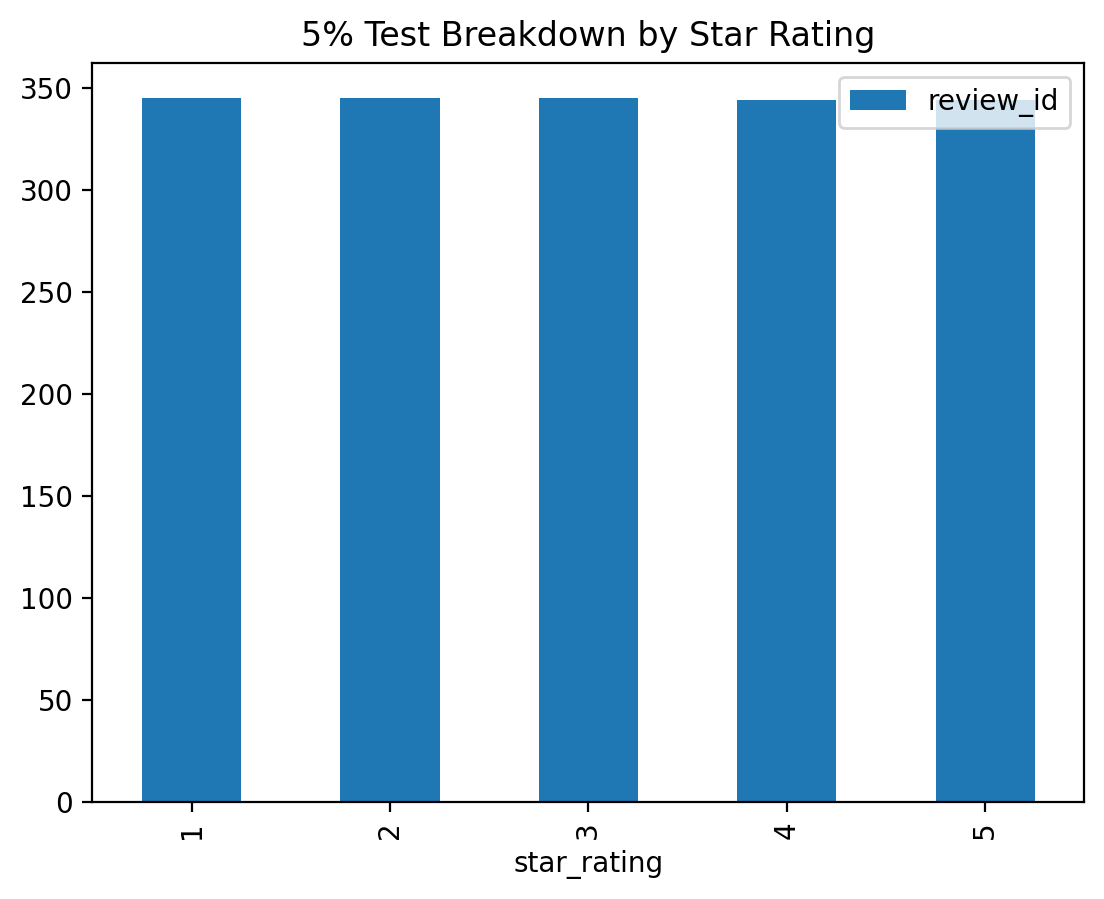

In [25]:
df_test[["star_rating", "review_id"]].groupby("star_rating").count().plot(
    kind="bar", title="5% Test Breakdown by Star Rating"
)

# Select `star_rating` and `review_body` for Training

In [26]:
df_train = df_train[["star_rating", "review_body"]]
df_train.shape

(31005, 2)

In [27]:
df_train.head(5)

,star_rating,review_body
1051,1,Crashed TWICE on my mid 2013 MacBook Air with ...
32534,5,I was a bit skeptical at first when I heard Ad...
4852,1,Won't run on my iMac and amazon won't respond ...
31168,5,I have used the free version of AVAST for seve...
25761,4,Avast free antivirus makes it easy to use. Pa...


# Write a CSV With No Header for Comprehend 

In [28]:
comprehend_train_path = "./amazon_reviews_us_Digital_Software_v1_00_comprehend.csv"
df_train.to_csv(comprehend_train_path, index=False, header=False)

# Upload Train Data to S3 for Comprehend

In [29]:
train_s3_prefix = "data"
comprehend_train_s3_uri = sess.upload_data(path=comprehend_train_path, key_prefix=train_s3_prefix)
comprehend_train_s3_uri

's3://sagemaker-us-east-1-992382405090/data/amazon_reviews_us_Digital_Software_v1_00_comprehend.csv'

In [30]:
!aws s3 ls $comprehend_train_s3_uri

2024-07-08 08:54:34   13733932 amazon_reviews_us_Digital_Software_v1_00_comprehend.csv


# Store the location of our train data in our notebook server to be used next

In [31]:
%store comprehend_train_s3_uri

Stored 'comprehend_train_s3_uri' (str)


In [32]:
%store

Stored variables and their in-db values:
USE_FULL_MOVIELENS                     -> False
bucket_name                            -> '992382405090personalizepocvod'
comprehend_train_s3_uri                -> 's3://sagemaker-us-east-1-992382405090/data/amazon
data_dir                               -> 'poc_data'
dataset_dir                            -> 'poc_data/ml-latest-small/'
dataset_group_arn                      -> 'arn:aws:personalize:us-east-1:992382405090:datase
forecast_arn                           -> 'arn:aws:forecast:us-east-1:992382405090:forecast/
forecast_dataset_arn                   -> 'arn:aws:forecast:us-east-1:992382405090:dataset/u
forecast_dataset_group_arn             -> 'arn:aws:forecast:us-east-1:992382405090:dataset-g
forecast_predictor_arn                 -> 'arn:aws:forecast:us-east-1:992382405090:predictor
forecast_project_name                  -> 'util_power_forecast'
forecast_role_name                     -> 'ForecastNotebookRole'
interactions_dataset_arn   

# Release Resources

In [34]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>

In [33]:
%%javascript

try {
    Jupyter.notebook.save_checkpoint();
    Jupyter.notebook.session.delete();
}
catch(err) {
    // NoOp
}

<IPython.core.display.Javascript object>

# Prepare Dataset for Model Training and Evaluating

# Amazon Customer Reviews Dataset

https://s3.amazonaws.com/dsoaws/amazon-reviews-pds/readme.html

## Schema

- `marketplace`: 2-letter country code (in this case all "US").
- `customer_id`: Random identifier that can be used to aggregate reviews written by a single author.
- `review_id`: A unique ID for the review.
- `product_id`: The Amazon Standard Identification Number (ASIN).  `http://www.amazon.com/dp/<ASIN>` links to the product's detail page.
- `product_parent`: The parent of that ASIN.  Multiple ASINs (color or format variations of the same product) can roll up into a single parent.
- `product_title`: Title description of the product.
- `product_category`: Broad product category that can be used to group reviews (in this case digital videos).
- `star_rating`: The review's rating (1 to 5 stars).
- `helpful_votes`: Number of helpful votes for the review.
- `total_votes`: Number of total votes the review received.
- `vine`: Was the review written as part of the [Vine](https://www.amazon.com/gp/vine/help) program?
- `verified_purchase`: Was the review from a verified purchase?
- `review_headline`: The title of the review itself.
- `review_body`: The text of the review.
- `review_date`: The date the review was written.

In [1]:
import boto3
import sagemaker
import pandas as pd

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

## Download

Let's start by retrieving a subset of the Amazon Customer Reviews dataset.

In [9]:
!aws s3 cp 's3://dsoaws/amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Software_v1_00.tsv.gz' ./data/

download: s3://dsoaws/amazon-reviews-pds/tsv/amazon_reviews_us_Digital_Software_v1_00.tsv.gz to data/amazon_reviews_us_Digital_Software_v1_00.tsv.gz


In [10]:
import csv

df = pd.read_csv(
    "./data/amazon_reviews_us_Digital_Software_v1_00.tsv.gz",
    delimiter="\t",
    quoting=csv.QUOTE_NONE,
    compression="gzip",
)
df.shape

(102084, 15)

In [11]:
df.head(5)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,17747349,R2EI7QLPK4LF7U,B00U7LCE6A,106182406,CCleaner Free [Download],Digital_Software,4,0,0,N,Y,Four Stars,So far so good,2015-08-31
1,US,10956619,R1W5OMFK1Q3I3O,B00HRJMOM4,162269768,ResumeMaker Professional Deluxe 18,Digital_Software,3,0,0,N,Y,Three Stars,Needs a little more work.....,2015-08-31
2,US,13132245,RPZWSYWRP92GI,B00P31G9PQ,831433899,Amazon Drive Desktop [PC],Digital_Software,1,1,2,N,Y,One Star,Please cancel.,2015-08-31
3,US,35717248,R2WQWM04XHD9US,B00FGDEPDY,991059534,Norton Internet Security 1 User 3 Licenses,Digital_Software,5,0,0,N,Y,Works as Expected!,Works as Expected!,2015-08-31
4,US,17710652,R1WSPK2RA2PDEF,B00FZ0FK0U,574904556,SecureAnywhere Intermet Security Complete 5 De...,Digital_Software,4,1,2,N,Y,Great antivirus. Worthless customer support,I've had Webroot for a few years. It expired a...,2015-08-31


Text(0, 0.5, 'Review Count')

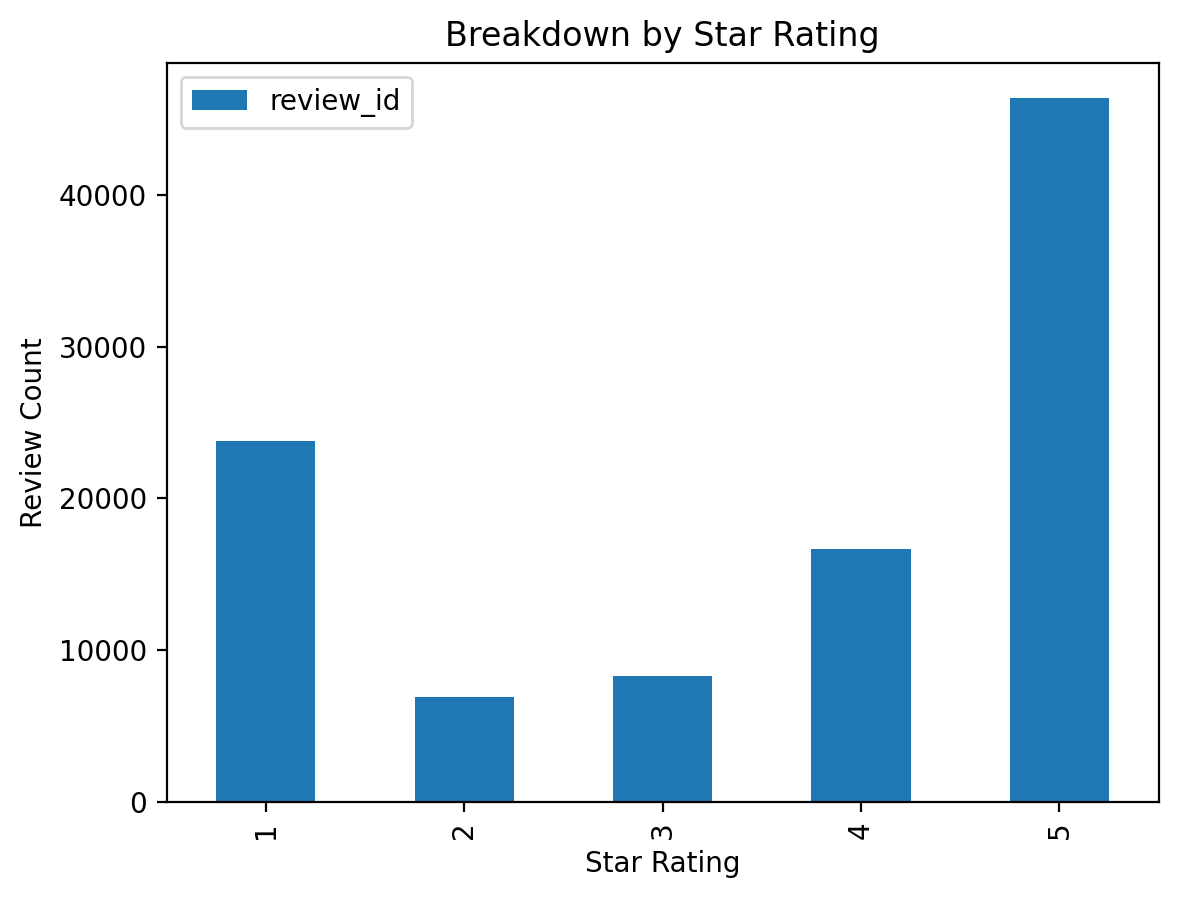

In [12]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

df[["star_rating", "review_id"]].groupby("star_rating").count().plot(kind="bar", title="Breakdown by Star Rating")
plt.xlabel("Star Rating")
plt.ylabel("Review Count")

# Balance the Dataset

In [13]:
print("Shape of dataframe before splitting {}".format(df.shape))

Shape of dataframe before splitting (102084, 15)


In [14]:
# Balance the dataset down to the minority class
df_grouped_by = df.groupby(["star_rating"]) 
df_balanced = df_grouped_by.apply(lambda x: x.sample(df_grouped_by.size().min()).reset_index(drop=True))

df_balanced = df_balanced.reset_index(drop=True)
print("Shape of balanced dataframe {}".format(df_balanced.shape))

Shape of balanced dataframe (34450, 15)


Text(0, 0.5, 'Review Count')

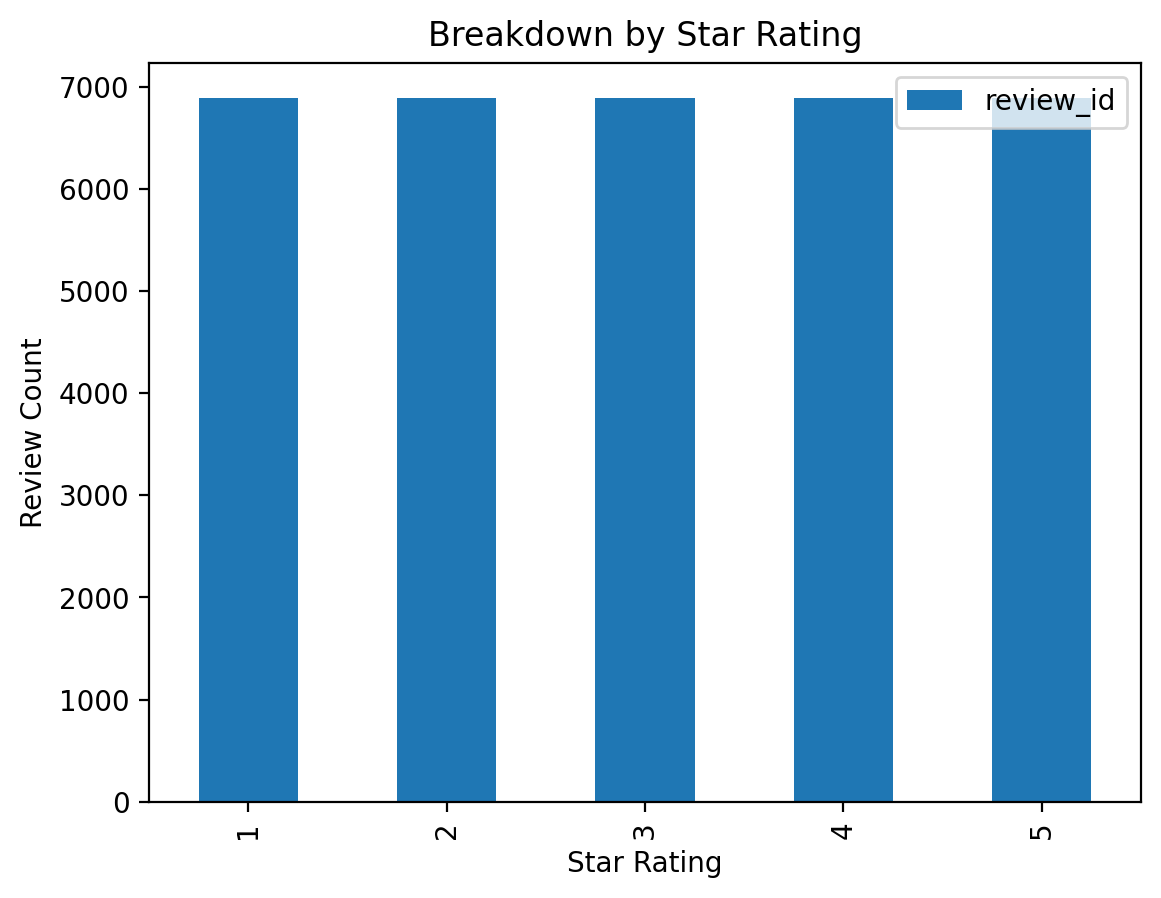

In [15]:
df_balanced[["star_rating", "review_id"]].groupby("star_rating").count().plot(
    kind="bar", title="Breakdown by Star Rating"
)
plt.xlabel("Star Rating")
plt.ylabel("Review Count")

In [16]:
df_balanced.head(5)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,47652876,R35PJ3ALKXTWS8,B00IG20XM4,466462406,avast! GrimeFighter [Download],Digital_Software,1,1,1,N,N,Avoid.,Doesn't work. Absolutely no response received ...,2014-10-15
1,US,6739894,R1KUZWDSZ65541,B008SCMUUA,832031006,Norton Internet Security 2013 - 1 User / 3 PC,Digital_Software,1,1,3,N,N,Fixing Virus and then charging you $99.99.,You buy the product and then you pay them to r...,2013-06-26
2,US,10630965,RPXAG6F94YJD4,B009T8GP1C,292346829,PhotoDirector 4,Digital_Software,1,0,1,N,Y,Can't even open it....,You guys at Amazon should be available to help...,2013-12-22
3,US,29022796,R2CJQ93YAGW1Q8,B008S0IP38,383426331,Quicken Premier 2013,Digital_Software,1,17,17,N,Y,Very buggy,I am really disappointed by this product. Its ...,2012-10-11
4,US,51877055,R3JUWY894GNA7O,B00NG7JVSQ,811978073,TurboTax Deluxe Fed + Efile + State,Digital_Software,1,1,1,N,N,DO NOT WASTE YOUR MONEY,I wish I could give this a ZERO. I'm halfway ...,2015-02-27


# Split the Data into Train, Validation, and Test Sets

In [17]:
from sklearn.model_selection import train_test_split

# Split all data into 90% train and 10% holdout
df_train, df_holdout = train_test_split(df_balanced, test_size=0.10, stratify=df_balanced["star_rating"])

# Split holdout data into 50% validation and 50% test
df_validation, df_test = train_test_split(df_holdout, test_size=0.50, stratify=df_holdout["star_rating"])

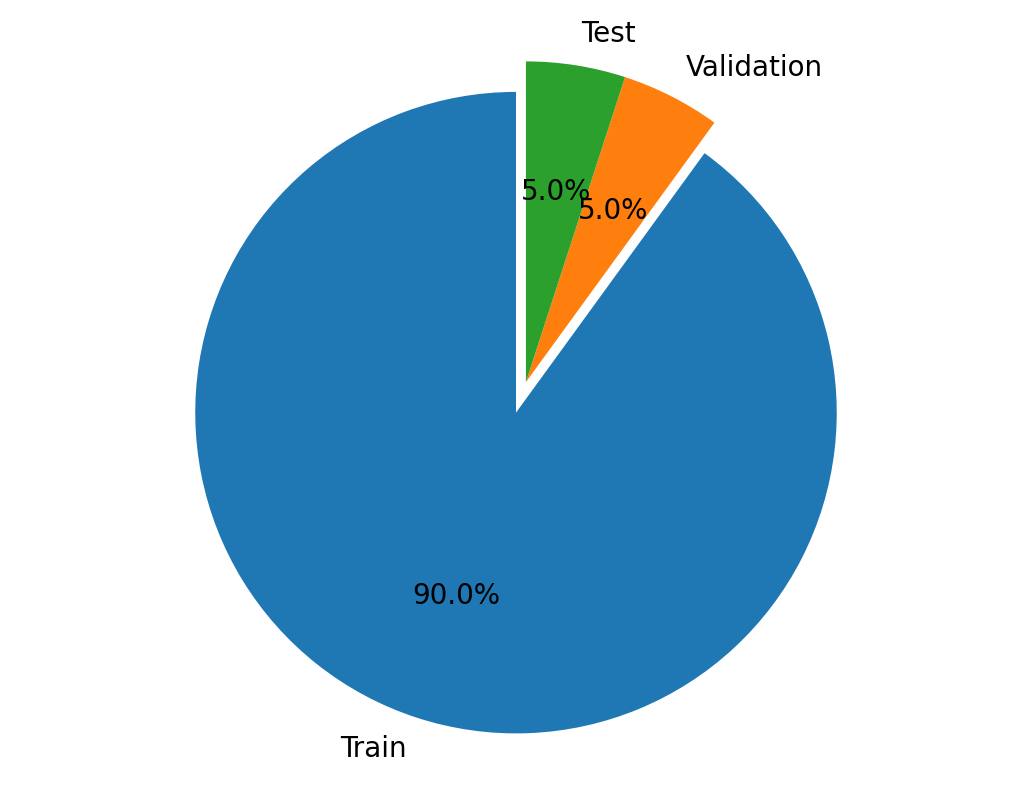

In [18]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ["Train", "Validation", "Test"]
sizes = [len(df_train.index), len(df_validation.index), len(df_test.index)]
explode = (0.1, 0, 0)

fig1, ax1 = plt.subplots()

ax1.pie(sizes, explode=explode, labels=labels, autopct="%1.1f%%", startangle=90)

# Equal aspect ratio ensures that pie is drawn as a circle.
ax1.axis("equal")

plt.show()

# Show 90% Train Data Split

In [19]:
df_train.shape

(31005, 15)

<Axes: title={'center': '90% Train Breakdown by Star Rating'}, xlabel='star_rating'>

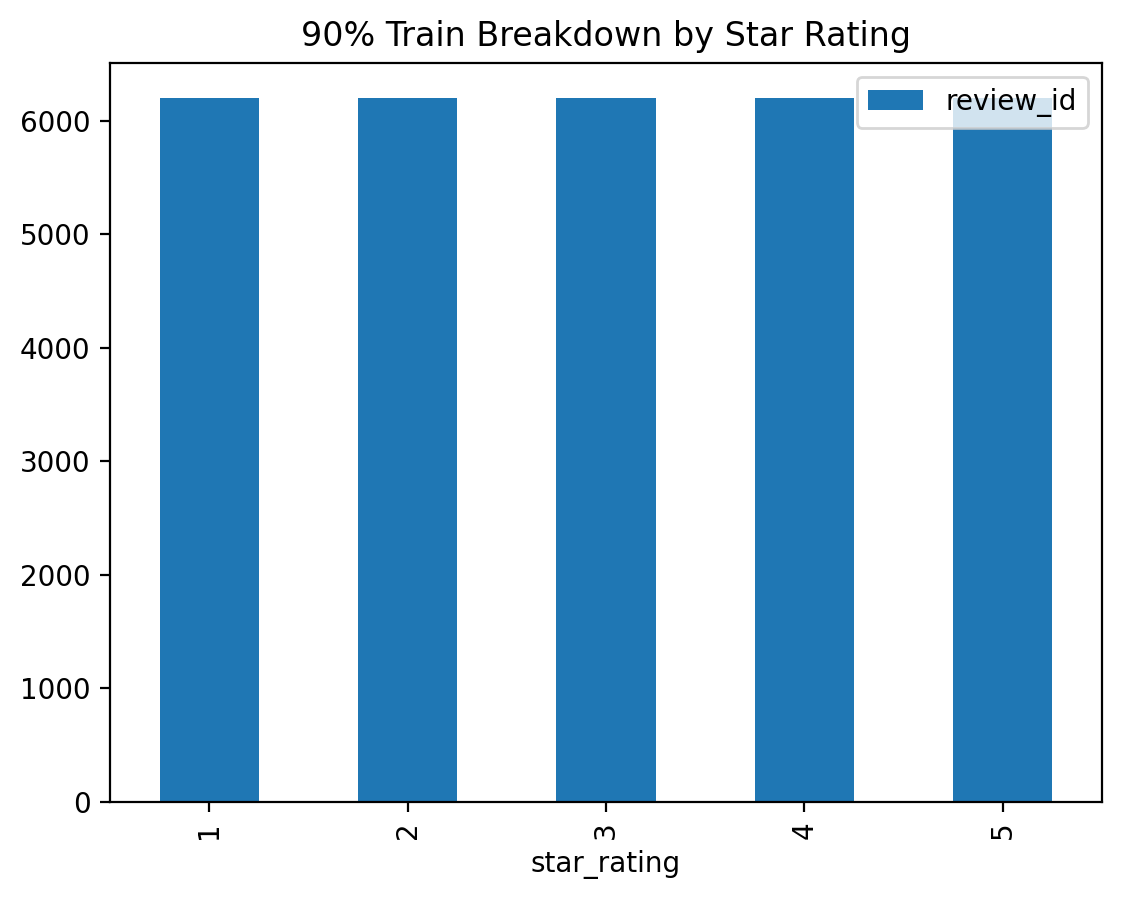

In [21]:
df_train[["star_rating", "review_id"]].groupby("star_rating").count().plot(
    kind="bar", title="90% Train Breakdown by Star Rating"
)

# Show 5% Validation Data Split

In [22]:
df_validation.shape

(1722, 15)

<Axes: title={'center': '5% Validation Breakdown by Star Rating'}, xlabel='star_rating'>

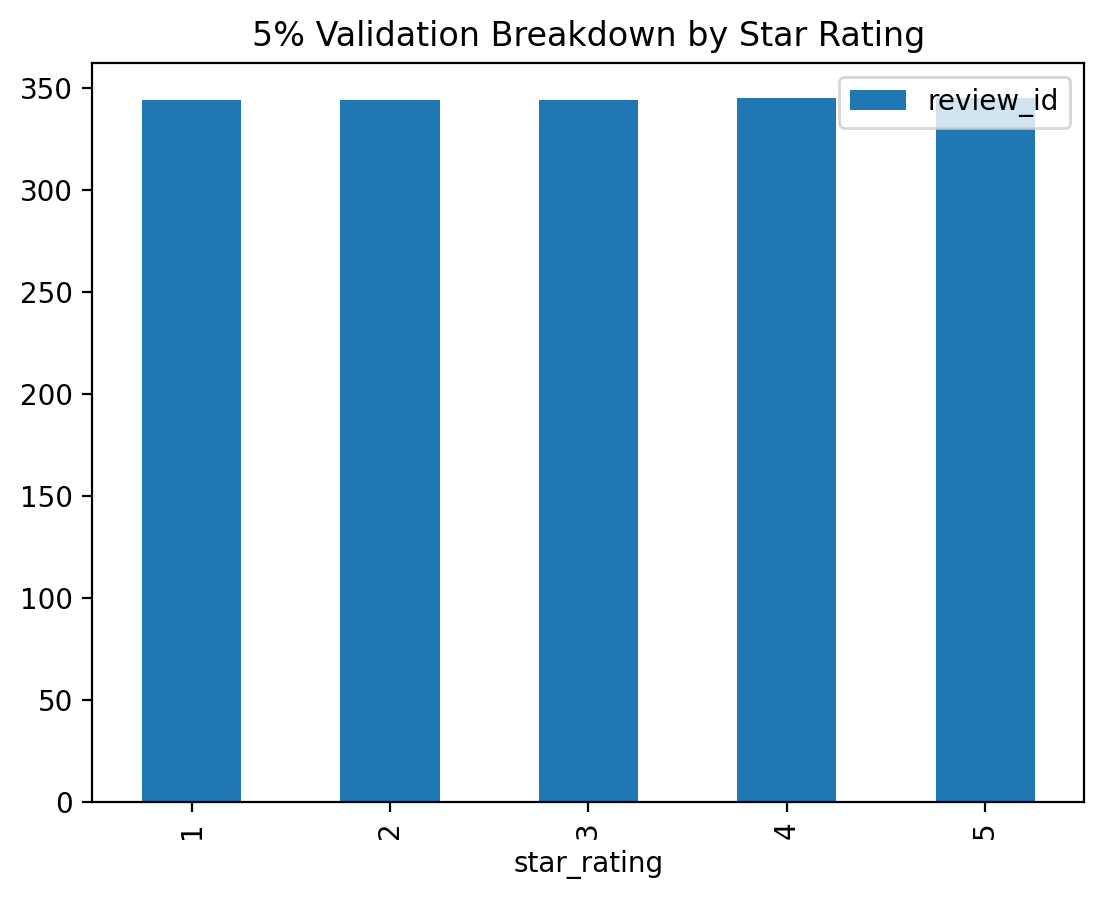

In [23]:
df_validation[["star_rating", "review_id"]].groupby("star_rating").count().plot(
    kind="bar", title="5% Validation Breakdown by Star Rating"
)

# Show 5% Test Data Split

In [24]:
df_test.shape

(1723, 15)

<Axes: title={'center': '5% Test Breakdown by Star Rating'}, xlabel='star_rating'>

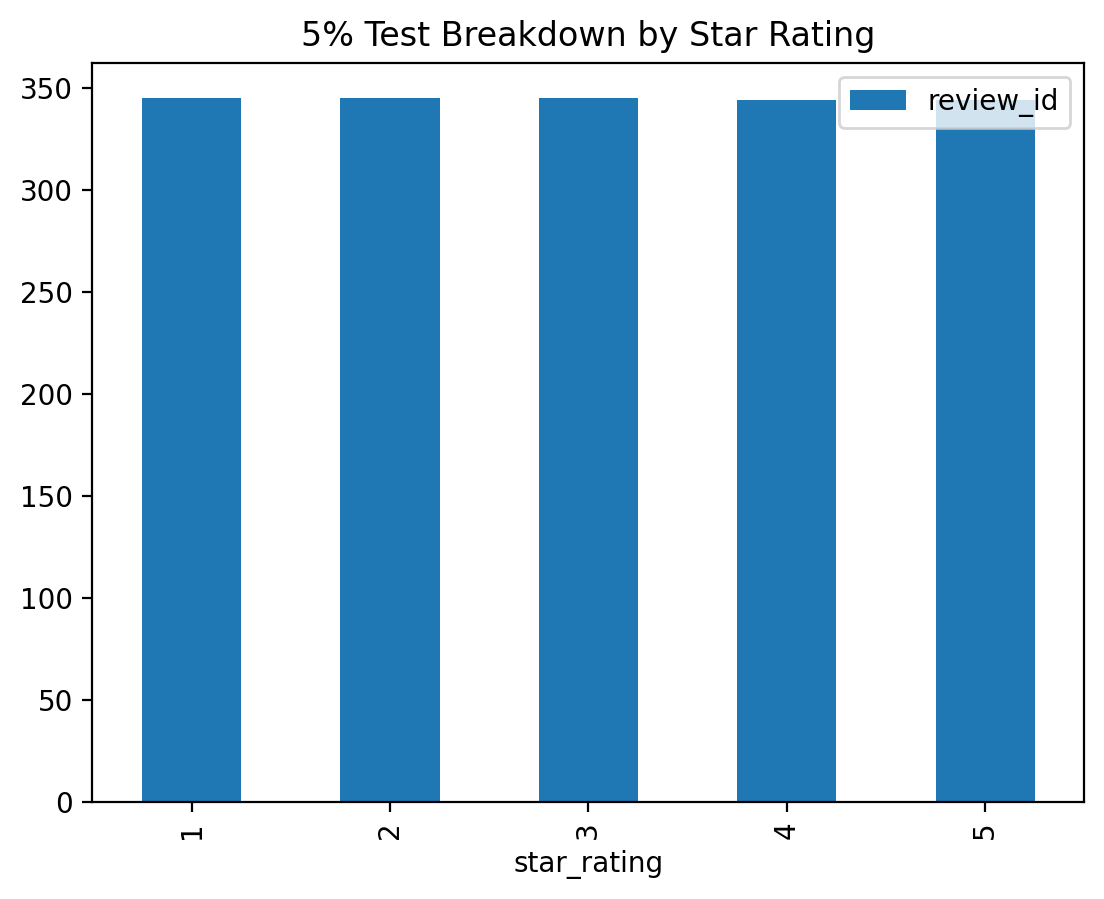

In [25]:
df_test[["star_rating", "review_id"]].groupby("star_rating").count().plot(
    kind="bar", title="5% Test Breakdown by Star Rating"
)

# Select `star_rating` and `review_body` for Training

In [26]:
df_train = df_train[["star_rating", "review_body"]]
df_train.shape

(31005, 2)

In [27]:
df_train.head(5)

,star_rating,review_body
1051,1,Crashed TWICE on my mid 2013 MacBook Air with ...
32534,5,I was a bit skeptical at first when I heard Ad...
4852,1,Won't run on my iMac and amazon won't respond ...
31168,5,I have used the free version of AVAST for seve...
25761,4,Avast free antivirus makes it easy to use. Pa...


# Write a CSV With No Header for Comprehend 

In [28]:
comprehend_train_path = "./amazon_reviews_us_Digital_Software_v1_00_comprehend.csv"
df_train.to_csv(comprehend_train_path, index=False, header=False)

# Upload Train Data to S3 for Comprehend

In [29]:
train_s3_prefix = "data"
comprehend_train_s3_uri = sess.upload_data(path=comprehend_train_path, key_prefix=train_s3_prefix)
comprehend_train_s3_uri

's3://sagemaker-us-east-1-992382405090/data/amazon_reviews_us_Digital_Software_v1_00_comprehend.csv'

In [30]:
!aws s3 ls $comprehend_train_s3_uri

2024-07-08 08:54:34   13733932 amazon_reviews_us_Digital_Software_v1_00_comprehend.csv


# Store the location of our train data in our notebook server to be used next

In [31]:
%store comprehend_train_s3_uri

Stored 'comprehend_train_s3_uri' (str)


In [32]:
%store

Stored variables and their in-db values:
USE_FULL_MOVIELENS                     -> False
bucket_name                            -> '992382405090personalizepocvod'
comprehend_train_s3_uri                -> 's3://sagemaker-us-east-1-992382405090/data/amazon
data_dir                               -> 'poc_data'
dataset_dir                            -> 'poc_data/ml-latest-small/'
dataset_group_arn                      -> 'arn:aws:personalize:us-east-1:992382405090:datase
forecast_arn                           -> 'arn:aws:forecast:us-east-1:992382405090:forecast/
forecast_dataset_arn                   -> 'arn:aws:forecast:us-east-1:992382405090:dataset/u
forecast_dataset_group_arn             -> 'arn:aws:forecast:us-east-1:992382405090:dataset-g
forecast_predictor_arn                 -> 'arn:aws:forecast:us-east-1:992382405090:predictor
forecast_project_name                  -> 'util_power_forecast'
forecast_role_name                     -> 'ForecastNotebookRole'
interactions_dataset_arn   

# Release Resources

In [34]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>

In [33]:
%%javascript

try {
    Jupyter.notebook.save_checkpoint();
    Jupyter.notebook.session.delete();
}
catch(err) {
    // NoOp
}

<IPython.core.display.Javascript object>